# Генерация диалогов банковской поддержки с клиентами и их классификация по последенему сообщению

# Генерация данных

### Основная логика:
Две отдельные функции:

*generate_user_message()* - для генерации сообщений пользователя

*generate_assistant_response()* - для генерации ответов сотрудника банка


**Поэтапная генерация диалога:**

Функция *generate_dialogue_step_by_step()* создает диалог пошагово:

* Генерирует сообщение пользователя
* Передает историю диалога в модель для генерации ответа ассистента
* Повторяет процесс для нужного количества оборотов
* Завершает финальным сообщением пользователя с ключевыми словами

In [ ]:
# установка llama-cpp-python
!pip install --no-cache-dir llama-cpp-python==0.2.90 --extra-index-url https://abetlen.github.io/llama-cpp-python/whl/cu123

Looking in indexes: https://pypi.org/simple, https://abetlen.github.io/llama-cpp-python/whl/cu123
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 444.5/444.5 MB 108.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 147.6 MB/s eta 0:00:00


In [ ]:
import os
import random
import torch
from llama_cpp import Llama
import json

In [ ]:
llm = Llama.from_pretrained(
	repo_id="yandex/YandexGPT-5-Lite-8B-instruct-GGUF",
	filename="YandexGPT-5-Lite-8B-instruct-Q4_K_M.gguf",
  n_gpu_layers=-1,
	n_ctx=2048,
	n_batch=512,
	verbose=False
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


YandexGPT-5-Lite-8B-instruct-Q4_K_M.gguf:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

Для каждого класса создадим ключевые слова, на основе которых llm будет генерировать диалоги

In [ ]:
CLASSES_INFO = {
    "block_card": {
        "russian_name": "Заблокировать карту",
        "keywords": [
            "заблокировать",
            "карта",
            "карточка",
            "потерял",
            "утеря",
            "украли",
            "кража",
            "блокировка",
            "остановить",
            "незамедлительно",
            "срочно"
        ]
    },
    "check_transfer_status": {
        "russian_name": "Узнать статус денежного перевода",
        "keywords": [
            "статус",
            "перевод",
            "трансфер",
            "прошёл",
            "отправил",
            "получил",
            "отслеживание",
            "задержка",
            "номер",
            "межбанк",
            "контроль"
        ]
    },
    "credit_application_status": {
        "russian_name": "Узнать статус заявки на кредит",
        "keywords": [
            "заявка",
            "кредит",
            "ипотека",
            "одобрить",
            "рассмотрение",
            "решение",
            "анкета",
            "статус",
            "условия",
            "внесён"
        ]
    },
    "unblock_card": {
        "russian_name": "Разблокировать карту",
        "keywords": [
            "разблокировать",
            "разблокировка",
            "карта",
            "карточка",
            "возврат",
            "идентификация",
            "вернуть",
            "доступ",
            "снять блок",
            "разрешить"
        ]
    },
    "change_pin": {
        "russian_name": "Сменить ПИН-код карты",
        "keywords": [
            "PIN",
            "пин",
            "смена",
            "код",
            "установить",
            "изменить",
            "аннулировать",
            "защитный код",
            "пароль",
            "обновить"
        ]
    },
    "open_new_account": {
        "russian_name": "Открыть новый счёт",
        "keywords": [
            "новый",
            "счёт",
            "открытие",
            "зарегистрировать",
            "регистрация",
            "документы",
            "завести",
            "открыть",
            "депозит",
            "баланс"
        ]
    },
    "close_account": {
        "russian_name": "Закрыть счёт",
        "keywords": [
            "закрыть",
            "ликвидировать",
            "счёт",
            "закрытие",
            "остаток",
            "анкета",
            "уведомить",
            "расторгнуть",
            "завершить",
            "закончить"
        ]
    },
    "get_account_statement": {
        "russian_name": "Получить выписку по счёту",
        "keywords": [
            "выписка",
            "PDF",
            "архив",
            "операции",
            "отчёт",
            "история",
            "за период",
            "баланс",
            "скачать",
            "электронная"
        ]
    },
    "transfer_fees_info": {
        "russian_name": "Узнать комиссию за денежный перевод",
        "keywords": [
            "комиссия",
            "тариф",
            "сбор",
            "расчёт",
            "минимальный",
            "процент",
            "плата",
            "стоимость",
            "условия",
            "дополнительный"
        ]
    },
    "loan_interest_rate_info": {
        "russian_name": "Узнать процентную ставку по кредиту",
        "keywords": [
            "ставка",
            "процент",
            "график",
            "аннуитет",
            "переплата",
            "годовой",
            "условия",
            "размер",
            "loan",
            "тавка"
        ]
    },
    "report_fraudulent_activity": {
        "russian_name": "Сообщить о мошеннической операции",
        "keywords": [
            "мошенничество",
            "подозрительная",
            "несанкционированная",
            "заявление",
            "списание",
            "жалоба",
            "обман",
            "фрод",
            "зафиксировать",
            "сообщить"
        ]
    },
    "update_personal_information": {
        "russian_name": "Обновить личные данные",
        "keywords": [
            "обновить",
            "контакт",
            "телефон",
            "мобильный",
            "адрес",
            "email",
            "почта",
            "сменить",
            "данные",
            "корректировка"
        ]
    },
    "app_technical_issue": {
        "russian_name": "Техническая проблема с приложением/интернет-банком",
        "keywords": [
            "сбой",
            "вылет",
            "зависает",
            "подключение",
            "лаг",
            "ошибка",
            "не работает",
            "авария",
            "глюк",
            "не запускается"
        ]
    },
    "forgot_password_login": {
        "russian_name": "Забыл пароль или логин от интернет-банка",
        "keywords": [
            "пароль",
            "логин",
            "восстановить",
            "сброс",
            "доступ",
            "забыли",
            "не помню",
            "войти",
            "учётная запись",
            "восстановление"
        ]
    },
    "currency_exchange_rates": {
        "russian_name": "Узнать актуальные курсы обмена валют",
        "keywords": [
            "курс",
            "валюта",
            "обмен",
            "доллар",
            "евро",
            "курс обмена",
            "USD",
            "EUR",
            "конвертер",
            "курс ЦБ"
        ]
    }
}

print(f"Всего классов: {len(CLASSES_INFO)}")

Всего классов: 15


In [ ]:
def generate_user_message(intent_key: str, intent_russian_name: str, keywords: list, dialogue_history: str = "", is_final: bool = False) -> str:
    """
    Генерирует сообщение пользователя для заданного интента.
    is_final - флаг последнего сообщения
    """
    if is_final:
        # Финальное сообщение
        selected_keywords = random.sample(keywords, min(3, len(keywords)))

        prompt = f"""<start_of_turn>user
                      На основе предыдущего диалога создай финальное сообщение клиента, которое четко выражает намерение "{intent_russian_name}":

                      {dialogue_history}

                      ОБЯЗАТЕЛЬНЫЕ требования:
                      1. Сообщение должно начинаться СТРОГО с "user:":
                      2. Сообщение ДОЛЖНО четко выражать интент "{intent_russian_name}"
                      3. Используй ключевые слова: {', '.join(selected_keywords)}
                      4. Сообщение должно быть конкретным и однозначным
                      5. Длина: 1-2 предложения
                      6. Это должна быть четкая просьба или заявление о намерении на русском языке.

                      Создай ТОЛЬКО финальное сообщение клиента БЕЗ специальных символов, которое однозначно выражает интент "{intent_russian_name}". <end_of_turn>

                      Пример: user: [финальное соощение пользователя]
                      <start_of_turn>model"""
    else:
        # Обычное сообщение в диалоге
        selected_keywords = random.sample(keywords, min(2, len(keywords)))

        if not dialogue_history:
            # Первое сообщение пользователя
            prompt = f"""<start_of_turn>user
                          Создай естественное обращение клиента в банк по теме "{intent_russian_name}".
                          Сообщение может содержать некоторые из этих ключевых слов: {', '.join(selected_keywords)}.

                          Требования:
                          1. Сообщение должно быть естественным и реалистичным
                          2. Длина: 1-2 предложения
                          3. Тон: вежливый, но может содержать беспокойство если ситуация серьёзная
                          4. НЕ начинай с "Здравствуйте" или подобных приветствий
                          5. Сразу к делу, как реальный клиент

                          Примеры:
                          - Для блокировки карты: "У меня проблемы с картой"
                          - Для статуса перевода: "Хочу уточнить по поводу перевода"

                          Создай ТОЛЬКО сообщение клиента, без пояснений, не добавляй никакие специальные символы. <end_of_turn>
                          <start_of_turn>model"""
        else:
            # Продолжение диалога
            prompt = f"""<start_of_turn>user
                          На основе предыдущего диалога создай следующее сообщение клиента по теме "{intent_russian_name}":

                          {dialogue_history}

                          Требования:
                          1. Сообщение должно логично продолжать диалог
                          2. Может содержать ключевые слова: {', '.join(selected_keywords)}
                          3. Может быть уточняющий вопрос или дополнительная информация
                          4. Длина: 1-2 предложения
                          5. Тон должен соответствовать контексту

                          Создай ТОЛЬКО следующее сообщение клиента, без пояснений, не добавляй никакие специальные символы. <end_of_turn>
                          <start_of_turn>model"""

    result = llm(
        prompt=prompt,
        max_tokens=100,
        temperature=0.8 if not is_final else 0.7,  # температура для финального сообщения меньше
        top_p=0.9,
        top_k=40,
        stop=["<end_of_turn>"],
        echo=False
    )

    response_text = result['choices'][0]['text'].strip()
    response_text = response_text.replace("user:", "").replace("Клиент:", "").strip()

    return response_text

In [ ]:
def generate_assistant_response(dialogue_history: str, intent_russian_name: str) -> str:
    """
    Генерирует ответ сотрудника банка на основе истории диалога.
    """
    prompt = f"""<start_of_turn>user
                  Ты сотрудник службы поддержки банка. На основе диалога с клиентом создай профессиональный ответ:

                  {dialogue_history}

                  Требования:
                  1. Ответ должен быть профессиональным и вежливым
                  2. Соответствовать теме: {intent_russian_name}
                  3. Может содержать просьбу о дополнительной информации
                  4. Или предложение конкретных действий
                  5. Длина: 1-2 предложения
                  6. Тон: профессиональный, готовность помочь

                  Создай ТОЛЬКО ответ сотрудника банка, без пояснений:<end_of_turn>
                  <start_of_turn>model"""

    result = llm(
        prompt=prompt,
        max_tokens=100,
        temperature=0.7,
        top_p=0.9,
        top_k=40,
        stop=["<end_of_turn>"],
        echo=False
    )

    response_text = result['choices'][0]['text'].strip()
    response_text = response_text.replace("assistant:", "").replace("Сотрудник:", "").replace("Банк:", "").strip()

    return response_text

In [ ]:
def generate_dialogue_step_by_step(intent_key: str, intent_russian_name: str, keywords: list, num_turns: int = 2) -> str:
    """
    Генерирует диалог пошагово: сообщение пользователя -> ответ ассистента -> и т.д.
    Обязательно завершается финальным сообщением пользователя, четко выражающим интент.
    Диалог должен содержать минимум 3 реплики user и 3 реплики assistant.
    """

    dialogue_lines = []
    dialogue_history = ""

    for turn in range(num_turns):
        # сообщение пользователя (НЕ финальное)
        user_message = generate_user_message(intent_key, intent_russian_name, keywords, dialogue_history, is_final=False)
        if not user_message:
            print(f"Не удалось сгенерировать сообщение пользователя для оборота {turn + 1}")
            break

        dialogue_lines.append(f"user: {user_message}")
        dialogue_history = "\n".join(dialogue_lines)

        torch.cuda.empty_cache()

        # ответ ассистента
        assistant_response = generate_assistant_response(dialogue_history, intent_russian_name)
        if not assistant_response:
            print(f"Не удалось сгенерировать ответ ассистента для оборота {turn + 1}")
            break

        dialogue_lines.append(f"assistant: {assistant_response}")
        dialogue_history = "\n".join(dialogue_lines)

        torch.cuda.empty_cache()

    user_count = len([line for line in dialogue_lines if line.startswith("user:")])
    assistant_count = len([line for line in dialogue_lines if line.startswith("assistant:")])

    # Если не хватает реплик, добавляем дополнительные обороты
    while user_count < 2 or assistant_count < 1:
        print(f"Недостаточно реплик, добавить дополнительный оборот...")

        user_message = generate_user_message(intent_key, intent_russian_name, keywords, dialogue_history, is_final=False)
        if user_message:
            dialogue_lines.append(f"user: {user_message}")
            dialogue_history = "\n".join(dialogue_lines)
            user_count += 1
            torch.cuda.empty_cache()
        else:
            print("Не удалось сгенерировать дополнительное сообщение пользователя")
            break

        if assistant_count < 1:
            assistant_response = generate_assistant_response(dialogue_history, intent_russian_name)
            if assistant_response:
                dialogue_lines.append(f"assistant: {assistant_response}")
                dialogue_history = "\n".join(dialogue_lines)
                assistant_count += 1
                torch.cuda.empty_cache()
            else:
                print("Не удалось сгенерировать дополнительный ответ ассистента")
                break

    # финальное сообщение пользователя
    max_attempts = 5
    final_message = None

    for attempt in range(max_attempts):
        try:
            final_message = generate_user_message(intent_key, intent_russian_name, keywords, dialogue_history, is_final=True)
            if final_message and len(final_message.strip()) > 10:
                final_lower = final_message.lower()
                contains_keyword = any(keyword.lower() in final_lower for keyword in keywords)
                if contains_keyword:
                    break
                else:
                    print(f"Финальное сообщение не содержит ключевых слов, попытка {attempt + 1}")
            else:
                print(f"Финальное сообщение слишком короткое, попытка {attempt + 1}")
        except Exception as e:
            print(f"Ошибка при генерации финального сообщения, попытка {attempt + 1}: {e}")

        torch.cuda.empty_cache()

    if not final_message:
        # Если не удалось сгенерировать, то простое финальное сообщение вручную
        keyword = random.choice(keywords)
        fallback_messages = {
            "block_card": f"Помогите заблокировать карту, я её {keyword}",
            "check_transfer_status": f"Нужно узнать {keyword} денежного перевода",
            "credit_application_status": f"Какой {keyword} у моей заявки на кредит?",
            "unblock_card": f"Как {keyword} карту после блокировки?",
            "change_pin": f"Хочу сменить PIN-{keyword} карты",
            "open_new_account": f"Нужно открыть {keyword} счёт",
            "close_account": f"Хочу {keyword} свой счёт",
            "get_account_statement": f"Мне нужна {keyword} по счёту",
            "transfer_fees_info": f"Какая {keyword} за денежный перевод?",
            "loan_interest_rate_info": f"Какая процентная {keyword} по кредиту?",
            "report_fraudulent_activity": f"Хочу сообщить о {keyword} операции",
            "update_personal_information": f"Нужно {keyword} личные данные",
            "app_technical_issue": f"У меня {keyword} с приложением",
            "forgot_password_login": f"Забыл {keyword} от интернет-банка",
            "currency_exchange_rates": f"Какой сейчас {keyword} валют?"
        }
        final_message = fallback_messages.get(intent_key, f"Помогите с вопросом по теме {intent_russian_name}")
        print(f"Использовано запасное финальное сообщение для {intent_key}")

    dialogue_lines.append(f"user: {final_message}")

    # Финальная проверка длины диалога
    final_user_count = len([line for line in dialogue_lines if line.startswith("user:")])
    final_assistant_count = len([line for line in dialogue_lines if line.startswith("assistant:")])

    print(f"Итоговая длина диалога: {final_user_count} реплик user, {final_assistant_count} реплик assistant")

    if final_user_count < 2 or final_assistant_count < 1:
        print(f"ВНИМАНИЕ: Диалог не соответствует минимальным требованиям (минимум 3 реплики каждого участника)")

    return "\n".join(dialogue_lines)

Основной цикл генерации диалогов

In [ ]:
import time
t0 = time.time()

OUTPUT_DIR = '/content/dialogue_intents_stepwise'
os.makedirs(OUTPUT_DIR, exist_ok=True)

NUM_TRAIN_EXAMPLES_PER_CLASS = 20
NUM_TEST_EXAMPLES_PER_CLASS = 10
train_dataset = []
test_dataset = []

for idx, (intent_key, info) in enumerate(CLASSES_INFO.items()):
    print(f"\n--- Генерирую для класса: {intent_key} ({info['russian_name']}) ({idx+1}/{len(CLASSES_INFO)}) ---")

    # TRAIN
    print(f"Генерация {NUM_TRAIN_EXAMPLES_PER_CLASS} примеров для TRAIN...")
    gen_count = 0
    attempts = 0
    while gen_count < NUM_TRAIN_EXAMPLES_PER_CLASS and attempts < NUM_TRAIN_EXAMPLES_PER_CLASS * 4:  # Увеличили количество попыток
        attempts += 1
        try:
            dlg = generate_dialogue_step_by_step(intent_key, info['russian_name'], info['keywords'], num_turns=random.randint(1, 2))
            if dlg and len(dlg.strip()) > 0:
                lines = dlg.strip().split('\n')
                last_user_line = None
                for line in reversed(lines):
                    if line.strip().startswith('user:'):
                        last_user_line = line.strip()
                        break

                if last_user_line:
                    last_message = last_user_line.replace('user:', '').strip().lower()
                    contains_keyword = any(keyword.lower() in last_message for keyword in info['keywords'])

                    if contains_keyword:
                        train_dataset.append({"label": intent_key, "dialog": dlg})
                        gen_count += 1
                        print(f"  TRAIN: Сгенерировано {gen_count}/{NUM_TRAIN_EXAMPLES_PER_CLASS}")
                    else:
                        print(f"  TRAIN: Попытка {attempts} - последнее сообщение не содержит ключевых слов, повтор...")
                else:
                    print(f"  TRAIN: Попытка {attempts} - не найдено последнее сообщение пользователя, повтор...")
            else:
                print(f"  TRAIN: Попытка {attempts} - пустой диалог, повтор...")
        except Exception as e:
            print(f"  TRAIN: Ошибка в попытке {attempts}: {e}, повтор...")

        torch.cuda.empty_cache()

    if gen_count < NUM_TRAIN_EXAMPLES_PER_CLASS:
        print(f"ВНИМАНИЕ: Сгенерировано только {gen_count} TRAIN для класса {intent_key}")

    # TEST
    print(f"Генерация {NUM_TEST_EXAMPLES_PER_CLASS} примеров для TEST...")
    gen_count = 0
    attempts = 0
    while gen_count < NUM_TEST_EXAMPLES_PER_CLASS and attempts < NUM_TEST_EXAMPLES_PER_CLASS * 4:  # Увеличили количество попыток
        attempts += 1
        try:
            dlg = generate_dialogue_step_by_step(intent_key, info['russian_name'], info['keywords'], num_turns=random.randint(1, 2))
            if dlg and len(dlg.strip()) > 0:
                lines = dlg.strip().split('\n')
                last_user_line = None
                for line in reversed(lines):
                    if line.strip().startswith('user:'):
                        last_user_line = line.strip()
                        break

                if last_user_line:
                    last_message = last_user_line.replace('user:', '').strip().lower()
                    contains_keyword = any(keyword.lower() in last_message for keyword in info['keywords'])

                    if contains_keyword:
                        test_dataset.append({"label": intent_key, "dialog": dlg})
                        gen_count += 1
                        print(f"  TEST: Сгенерировано {gen_count}/{NUM_TEST_EXAMPLES_PER_CLASS}")
                    else:
                        print(f"  TEST: Попытка {attempts} - последнее сообщение не содержит ключевых слов, повтор...")
                else:
                    print(f"  TEST: Попытка {attempts} - не найдено последнее сообщение пользователя, повтор...")
            else:
                print(f"  TEST: Попытка {attempts} - пустой диалог, повтор...")
        except Exception as e:
            print(f"  TEST: Ошибка в попытке {attempts}: {e}, повтор...")

        torch.cuda.empty_cache()

    if gen_count < NUM_TEST_EXAMPLES_PER_CLASS:
        print(f"ВНИМАНИЕ: Сгенерировано только {gen_count} TEST для класса {intent_key}")

with open(os.path.join(OUTPUT_DIR, 'train_dataset.json'), 'w', encoding='utf-8') as f:
    json.dump(train_dataset, f, ensure_ascii=False, indent=4)
with open(os.path.join(OUTPUT_DIR, 'test_dataset.json'), 'w', encoding='utf-8') as f:
    json.dump(test_dataset, f, ensure_ascii=False, indent=4)

print("\n--- Генерация данных завершена ---")
print("Длительность генерации:", time.time() - t0, "sec")


--- Генерирую для класса: block_card (Заблокировать карту) (1/15) ---
Генерация 20 примеров для TRAIN...
Финальное сообщение не содержит ключевых слов, попытка 1
Итоговая длина диалога: 3 реплик user, 2 реплик assistant
  TRAIN: Сгенерировано 1/20
Недостаточно реплик, добавить дополнительный оборот...
Итоговая длина диалога: 3 реплик user, 1 реплик assistant
  TRAIN: Сгенерировано 2/20
Финальное сообщение не содержит ключевых слов, попытка 1
Финальное сообщение не содержит ключевых слов, попытка 2
Итоговая длина диалога: 3 реплик user, 2 реплик assistant
  TRAIN: Сгенерировано 3/20
Недостаточно реплик, добавить дополнительный оборот...
Итоговая длина диалога: 3 реплик user, 1 реплик assistant
  TRAIN: Сгенерировано 4/20
Недостаточно реплик, добавить дополнительный оборот...
Итоговая длина диалога: 3 реплик user, 1 реплик assistant
  TRAIN: Сгенерировано 5/20
Финальное сообщение не содержит ключевых слов, попытка 1
Итоговая длина диалога: 3 реплик user, 2 реплик assistant
  TRAIN: Сген

Примеры сгенерированных диалогов:

In [ ]:
printed_classes = set()
for item in train_dataset:
    label = item['label']
    if label not in printed_classes:
        print(f"Класс: {label} ({CLASSES_INFO[label]['russian_name']})")
        print("Диалог:")
        print(item['dialog'])
        print("-" * 50)
        printed_classes.add(label)

print(f"Итого сгенерировано:")
print(f"TRAIN: {len(train_dataset)} диалогов")
print(f"TEST: {len(test_dataset)} диалогов")

Класс: block_card (Заблокировать карту)
Диалог:
user: Моя карта пропала, заблокируйте её пожалуйста.
assistant: Конечно, я помогу вам с блокировкой карты. Пожалуйста, сообщите мне номер вашей карты и ваш номер телефона для подтверждения личности. Спасибо.
user: У меня нет физического номера карты, только виртуальная. Что мне делать?
assistant: Конечно, я помогу вам заблокировать вашу виртуальную карту. Пожалуйста, сообщите мне ваш номер телефона для подтверждения личности и ваш полный ФИО. Спасибо.
user: Моя карта была украдена, пожалуйста, заблокируйте ее немедленно.
--------------------------------------------------
Класс: check_transfer_status (Узнать статус денежного перевода)
Диалог:
user: Как дела с переводом, который я вчера отправил?
assistant: Добрый день! Уточните, пожалуйста, номер вашего перевода, чтобы я мог проверить его статус.
user: Я отправил перевод через систему быстрых платежей, номер перевода 1234567890. Проверь его статус, пожалуйста.
user: Проверь, пожалуйста, ст

# Обучение классификатора

In [ ]:
import json
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import torch
from torch.optim import AdamW
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizerFast
from transformers import BertForSequenceClassification
from transformers import get_linear_schedule_with_warmup
from tqdm import tqdm
import matplotlib.pyplot as plt

Открываем файлы с данными и кодируем метки

(Так как выбранный мной способ генерации занимает около 30 минут (в colab), я сохранил сгенерированные данные [тут](https://drive.google.com/drive/u/1/folders/1WMAo4ZZc_2t0JibmshpifXyn-nENLARt))

In [ ]:
#пути к сгенерированным данным
with open('/content/dialogue_intents_stepwise/train_dataset.json', 'r', encoding='utf-8') as f:
    train_data = json.load(f)
with open('/content/dialogue_intents_stepwise/test_dataset.json', 'r', encoding='utf-8') as f:
    test_data = json.load(f)

In [ ]:
def extract_last_user_message(dialog_text): # для задачи классификации последнего сообщения
    lines = dialog_text.strip().split('\n')
    for line in reversed(lines):
        if line.lower().startswith('user:'):
            return line.split(':', 1)[1].strip()
    return dialog_text  # fallback

In [ ]:
# если надо классифицировать не последнее сообщение, а весь диалог, раскомментировать
# train_texts = [item['dialog'] for item in train_data]
# test_texts = [item['dialog'] for item in test_data]

train_texts = [extract_last_user_message(item['dialog']) for item in train_data]
test_texts = [extract_last_user_message(item['dialog']) for item in test_data]

train_labels = [item['label'] for item in train_data]
test_labels = [item['label'] for item in test_data]

le = LabelEncoder()
train_labels_enc = le.fit_transform(train_labels)
test_labels_enc = le.transform(test_labels)

Модель и токенизатор

In [ ]:
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = BertTokenizerFast.from_pretrained('DeepPavlov/rubert-base-cased')

def tokenize(batch_texts, max_length=128):
    return tokenizer(
        batch_texts,
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors='pt'
    )

train_encodings = tokenize(train_texts)
test_encodings = tokenize(test_texts)


num_labels = len(le.classes_)

model = BertForSequenceClassification.from_pretrained(
    'DeepPavlov/rubert-base-cased',
    num_labels=num_labels
).to(device)

pytorch_model.bin:   0%|          | 0.00/714M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
class TextDataset(Dataset):
  def __init__(self, encodings, labels):
    self.encodings=encodings
    self.labels=labels

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    item = {key: tensor[idx] for key, tensor in self.encodings.items()}
    item['labels'] = torch.tensor(self.labels[idx])
    return item

train_dataset = TextDataset(train_encodings, train_labels_enc)
test_dataset = TextDataset(test_encodings, test_labels_enc)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

Настройка optimizer и scheduler

In [ ]:
optimizer = AdamW(model.parameters(), lr=2e-5)

num_epochs=7
total_steps=len(train_loader)*num_epochs
warmup_steps=int(0.1*total_steps)

scheduler = get_linear_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

Функции train и eval на одну эпоху

In [ ]:
def train_epoch():
    model.train()
    total_loss = 0
    progress_bar = tqdm(train_loader, desc='Training', position=0, leave=True)

    for batch in progress_bar:
        batch = {k: v.to(device) for k, v in batch.items()}

        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        total_loss += loss.item()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        progress_bar.set_postfix({'loss': loss.item()})

    return total_loss / len(train_loader)

def eval_epoch():
    model.eval()
    total_loss = 0
    correct = 0
    total_samples = 0

    with torch.no_grad():
        progress_bar = tqdm(test_loader, desc='Validation', position=0, leave=True)

        for batch in progress_bar:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)

            batch_size = batch['input_ids'].size(0)
            total_loss += outputs.loss.item() * batch_size

            preds = outputs.logits.argmax(dim=-1)
            correct += (preds == batch['labels']).sum().item()
            total_samples += batch_size

            progress_bar.set_postfix({'val_loss': outputs.loss.item()})

    avg_loss = total_loss / total_samples
    accuracy = correct / total_samples
    return avg_loss, accuracy

Основной цикл обучения с визуализацией

Validation: 100%|██████████| 10/10 [00:01<00:00,  9.36it/s, val_loss=2.55]


Epoch 1 — train_loss: 2.6760, val_loss: 2.6219, val_acc: 10.6667%


Validation: 100%|██████████| 10/10 [00:01<00:00,  9.37it/s, val_loss=1.84]


Epoch 2 — train_loss: 2.4685, val_loss: 2.2593, val_acc: 28.6667%


Validation: 100%|██████████| 10/10 [00:01<00:00,  8.98it/s, val_loss=1.02]


Epoch 3 — train_loss: 2.1080, val_loss: 1.8756, val_acc: 70.6667%


Validation: 100%|██████████| 10/10 [00:01<00:00,  9.05it/s, val_loss=0.721]


Epoch 4 — train_loss: 1.7390, val_loss: 1.5785, val_acc: 86.6667%


Validation: 100%|██████████| 10/10 [00:01<00:00,  9.26it/s, val_loss=0.52]


Epoch 5 — train_loss: 1.4723, val_loss: 1.3693, val_acc: 92.0000%


Validation: 100%|██████████| 10/10 [00:01<00:00,  9.39it/s, val_loss=0.452]


Epoch 6 — train_loss: 1.2971, val_loss: 1.2238, val_acc: 94.0000%


Validation: 100%|██████████| 10/10 [00:01<00:00,  9.42it/s, val_loss=0.407]


Epoch 7 — train_loss: 1.1979, val_loss: 1.1849, val_acc: 94.0000%


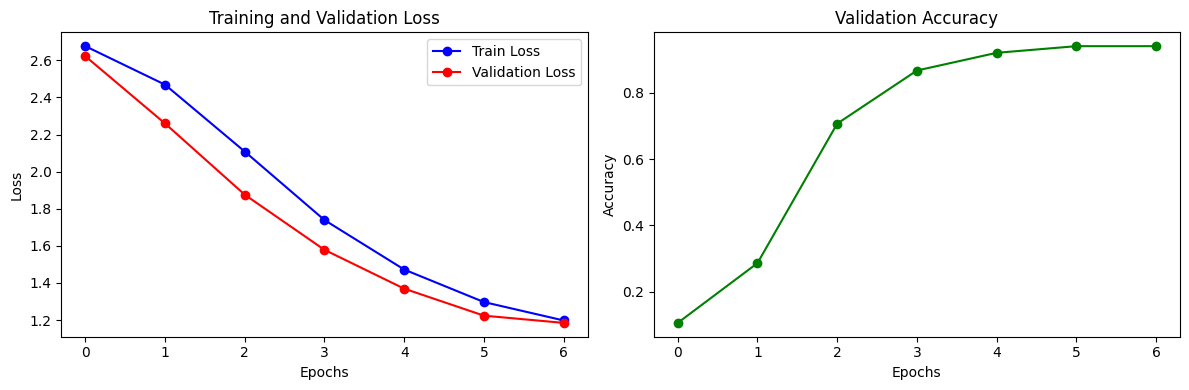

In [ ]:
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    train_loss = train_epoch()
    val_loss, val_acc = eval_epoch()

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1} — train_loss: {train_loss:.4f}, val_loss: {val_loss:.4f}, val_acc: {val_acc:.4%}")

# Графики loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, 'b-o', label='Train Loss')
plt.plot(val_losses, 'r-o', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# График accuracy
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, 'g-o')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.show()

Посмотрим, как модель классифицирует каждый класс

In [ ]:
def analyze_predictions():
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in test_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            preds = outputs.logits.argmax(dim=-1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch['labels'].cpu().numpy())

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds))

    print("\nConfusion Matrix:")
    print(confusion_matrix(all_labels, all_preds))

analyze_predictions()


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.77      1.00      0.87        10
           2       0.91      1.00      0.95        10
           3       1.00      0.80      0.89        10
           4       1.00      1.00      1.00        10
           5       1.00      1.00      1.00        10
           6       1.00      1.00      1.00        10
           7       0.91      1.00      0.95        10
           8       0.91      1.00      0.95        10
           9       0.75      0.90      0.82        10
          10       1.00      1.00      1.00        10
          11       1.00      1.00      1.00        10
          12       1.00      0.70      0.82        10
          13       1.00      0.70      0.82        10
          14       1.00      1.00      1.00        10

    accuracy                           0.94       150
   macro avg       0.95      0.94      0.94       150
we

# Заключение:
*   Модели вроде gemma-2b-it, mistral-7b-v0.1 не дали хороших результатов для текстов на русском, поэтому было решено использовать YandexGPT5. Также пробовал разные версии этой модели от [Vikhrмodels](https://huggingface.co/Vikhrmodels/Vikhr-YandexGPT-5-Lite-8B-it_GGUF/tree/main)
*   Для повышения качества диалогов очень помогло увеличение контекста(n_ctx).

*   С использованием llama скорость генерации в 3-4 раза выше, по сравнению с transformers
*   В целом, качество классификации напрямую зависит от качества сгенерированных данных